In [5]:
import qiskit
import qiskit.quantum_info
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer.noise import NoiseModel, depolarizing_error
import numpy as np
from qiskit_aer.primitives import Sampler as AerSampler
import matplotlib as plt

In [5]:
backend = AerSimulator()
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

In [6]:
def gen_chsh(x, y, num_qubits=2, phase=np.pi/4):

    base_qc = qiskit.QuantumCircuit(num_qubits, 2)

    base_qc.h(0)
    base_qc.cx(0, num_qubits - 1)

    if x == 1:
        base_qc.h(0)

    if y == 0:
        base_qc.ry(-phase, num_qubits - 1)
    elif y == 1:
        base_qc.ry(phase, num_qubits - 1)   

    base_qc.measure(0, 0)
    base_qc.measure(num_qubits-1, 1)
    #measure_all() #([0, 1], [0, 1])

    return base_qc

##### Why $\frac{\pi}{4}?$

The reason behind why $\frac{\pi}{4}$ is the optimal rotation in the y-axis is becuase of what basis Bob is measuring in. To achive Tsirelson's bound ($S = 2\sqrt2$) you start in the entangled bell state and then change the measurment basis based on values of $x$ and $y$. 

The following is based on this proof: https://math.ucsd.edu/sites/math.ucsd.edu/files/XiaoFeng.pdf

Let alice have the angles to meausre in be $\alpha, \alpha'$ and Bob have $\beta, \beta'$ and they share the bell state. Then their coorelation is
$$E(\alpha, \beta) = cos[2(\alpha -\beta)]$$
and the CHSH parameter becomes:
$$S = cos[2(\alpha -\beta)] - cos[2(\alpha' -\beta)] + cos[2(\alpha -\beta')] - cos[2(\alpha' -\beta')]$$

If we let $\alpha = 0, \alpha = \pi/2$ and $\beta = \theta, \beta' = \theta$ and we subsistue into the CHSH paramter we have:
$$S(\theta) = 4cos(2\theta)$$ 
amd to maximize $S(\theta)$ we need to find where the max of $cos(2\theta)$ occurs. We find that $\theta = \pi$ and $S$ can equal $4$, but this isn't physically realizable and the max of $S$ is futhere below that which is why $\theta$ can only go up to $\frac{\pi}{4}$.

In [7]:
import numpy as np

target = np.pi / 4 # want to make sure pi/4 is in the set of phases
start = -np.pi / 2
stop = 3 * np.pi

for N in range(31, 100):
    phases = np.linspace(start, stop, N)
    if np.any(np.isclose(phases, target, atol=1e-6)):
        print(f"Found a match with N = {N}")
        break

Found a match with N = 43


In [8]:
phases = np.linspace(-np.pi/2, 3*np.pi, 43)
print(phases)

[-1.57079633 -1.30899694 -1.04719755 -0.78539816 -0.52359878 -0.26179939
  0.          0.26179939  0.52359878  0.78539816  1.04719755  1.30899694
  1.57079633  1.83259571  2.0943951   2.35619449  2.61799388  2.87979327
  3.14159265  3.40339204  3.66519143  3.92699082  4.1887902   4.45058959
  4.71238898  4.97418837  5.23598776  5.49778714  5.75958653  6.02138592
  6.28318531  6.54498469  6.80678408  7.06858347  7.33038286  7.59218225
  7.85398163  8.11578102  8.37758041  8.6393798   8.90117919  9.16297857
  9.42477796]


In [9]:
circuits = []
input_pairs = []
for phase in phases:
    for x_in in [0, 1]:
        for y_in in [0, 1]:
            input_pairs.append((x_in, y_in))
            circuits.append(gen_chsh(x_in, y_in, num_qubits=6, phase=phase))

### Circuit Gen v2
only diffrence is that it has metadata so i can keep track of phase, x_in, and y_in

In [10]:
distance = 10# not code distance for qec lol!

In [11]:
circuits = []
metadata = [] 

for phase in phases:
    for x_in in [0, 1]:
        for y_in in [0, 1]:
            circuits.append(gen_chsh(x_in, y_in, num_qubits=distance, phase=phase))
            metadata.append({
                'phase': phase,
                'x_in': x_in,
                'y_in': y_in
            })

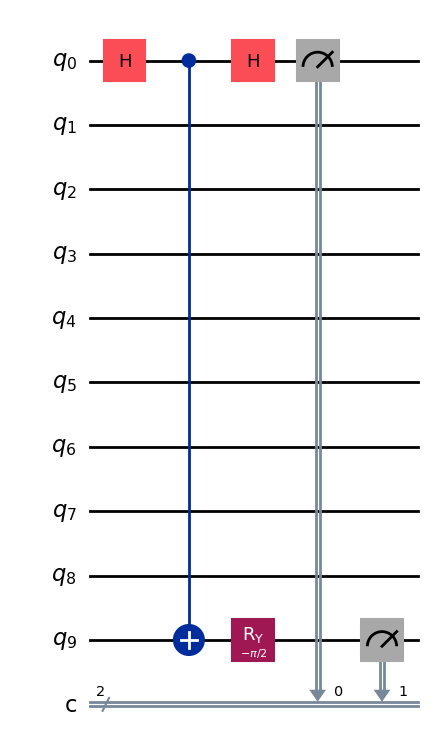

In [12]:
circuits[3].draw("mpl")

## Version 2
Noisy simulation with changes of phase

In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.backend(backend_name)
noise_model = NoiseModel.from_backend(backend)
SHOTS = 1024

In [14]:
from qiskit_aer import AerSimulator
from qiskit import transpile

simulator = AerSimulator(noise_model=noise_model)
#simulator = AerSimulator()
transpiled_circuits = [transpile(circ, simulator, optimization_level=3, layout_method="trivial") for circ in circuits]

results = simulator.run(transpiled_circuits, shots=SHOTS).result()
counts_list = [results.get_counts(i) for i in range(len(transpiled_circuits))]

In [15]:
coupling_map = backend.target.build_coupling_map()

pm = generate_preset_pass_manager(
    optimization_level=3, coupling_map=coupling_map, layout_method="trivial"
)

qc_oncm = pm.run(circuits[0])

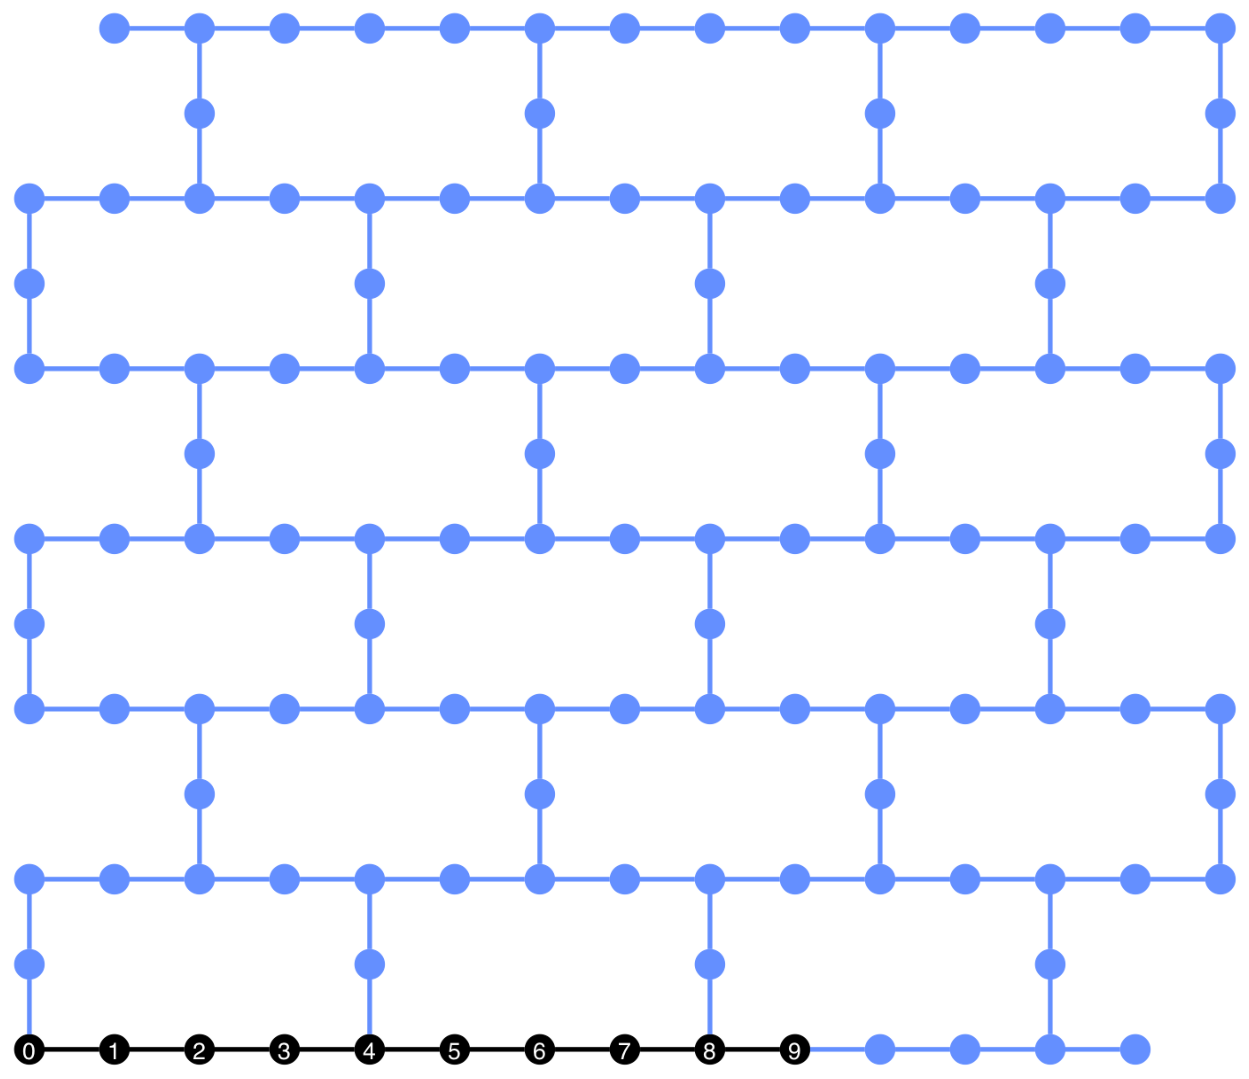

In [16]:
from qiskit.visualization import plot_circuit_layout
 
plot_circuit_layout(qc_oncm, backend, view="physical")

In [49]:
print(noise_model)

NoiseModel:
  Basis gates: ['cz', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'id', 'reset', 'measure', 'x', 'cz']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('reset', (5,)), ('reset', (6,)), ('reset', (7,)), ('reset', (8,)), ('reset', (9,)), ('reset', (10,)), ('reset', (11,)), ('reset', (12,)), ('reset', (13,))

In [50]:
for instruction in noise_model._local_quantum_errors:
    print(f"Instruction: {instruction}")
    for error in noise_model._local_quantum_errors[instruction]:
        print(f"  Applied to qubits: {error}")
        # print(f"  Error: {error.quantum_error}")

Instruction: reset
  Applied to qubits: (0,)
  Applied to qubits: (1,)
  Applied to qubits: (2,)
  Applied to qubits: (3,)
  Applied to qubits: (4,)
  Applied to qubits: (5,)
  Applied to qubits: (6,)
  Applied to qubits: (7,)
  Applied to qubits: (8,)
  Applied to qubits: (9,)
  Applied to qubits: (10,)
  Applied to qubits: (11,)
  Applied to qubits: (12,)
  Applied to qubits: (13,)
  Applied to qubits: (14,)
  Applied to qubits: (15,)
  Applied to qubits: (16,)
  Applied to qubits: (17,)
  Applied to qubits: (18,)
  Applied to qubits: (19,)
  Applied to qubits: (20,)
  Applied to qubits: (21,)
  Applied to qubits: (22,)
  Applied to qubits: (23,)
  Applied to qubits: (24,)
  Applied to qubits: (25,)
  Applied to qubits: (26,)
  Applied to qubits: (27,)
  Applied to qubits: (28,)
  Applied to qubits: (29,)
  Applied to qubits: (30,)
  Applied to qubits: (31,)
  Applied to qubits: (32,)
  Applied to qubits: (33,)
  Applied to qubits: (34,)
  Applied to qubits: (35,)
  Applied to qubits

In [51]:
results = list(zip(metadata, counts_list))

In [52]:
def get_expectation(counts):
    agree = counts.get('00', 0) + counts.get('11', 0)
    disagree = counts.get('01', 0) + counts.get('10', 0)
    return (agree - disagree) / SHOTS if SHOTS > 0 else 0

In [53]:
from collections import defaultdict

outputs = []
grouped_by_phase = defaultdict(list)

for meta, counts in results:
    phase = float(meta['phase'])  # ensure it's hashable (np.float64 isn't always)
    grouped_by_phase[phase].append((meta['x_in'], meta['y_in'], counts))


for phase, group in grouped_by_phase.items():
    # Sort by (x, y) to ensure correct order: (0,0), (0,1), (1,0), (1,1)
    expectations = []
    for x, y, counts in group:
        e = get_expectation(counts)
        print(f"Phase={phase:.4f} | E({x},{y}) = {e:.4f}")
        expectations.append(e)

    if len(expectations) == 4:
        chsh_value = expectations[0] + expectations[1] + expectations[2] - expectations[3]
        outputs.append((phase, chsh_value))
        print(f"→ CHSH for phase {phase:.4f}: {chsh_value:.4f}\n")

Phase=-1.5708 | E(0,0) = -0.0156
Phase=-1.5708 | E(0,1) = -0.0332
Phase=-1.5708 | E(1,0) = -1.0000
Phase=-1.5708 | E(1,1) = 1.0000
→ CHSH for phase -1.5708: -2.0488

Phase=-1.3090 | E(0,0) = 0.2109
Phase=-1.3090 | E(0,1) = 0.2676
Phase=-1.3090 | E(1,0) = -0.9570
Phase=-1.3090 | E(1,1) = 0.9570
→ CHSH for phase -1.3090: -1.4355

Phase=-1.0472 | E(0,0) = 0.4883
Phase=-1.0472 | E(0,1) = 0.4961
Phase=-1.0472 | E(1,0) = -0.8457
Phase=-1.0472 | E(1,1) = 0.8672
→ CHSH for phase -1.0472: -0.7285

Phase=-0.7854 | E(0,0) = 0.6934
Phase=-0.7854 | E(0,1) = 0.6855
Phase=-0.7854 | E(1,0) = -0.7012
Phase=-0.7854 | E(1,1) = 0.7227
→ CHSH for phase -0.7854: -0.0449

Phase=-0.5236 | E(0,0) = 0.8691
Phase=-0.5236 | E(0,1) = 0.8574
Phase=-0.5236 | E(1,0) = -0.5566
Phase=-0.5236 | E(1,1) = 0.4609
→ CHSH for phase -0.5236: 0.7090

Phase=-0.2618 | E(0,0) = 0.9727
Phase=-0.2618 | E(0,1) = 0.9688
Phase=-0.2618 | E(1,0) = -0.2461
Phase=-0.2618 | E(1,1) = 0.2520
→ CHSH for phase -0.2618: 1.4434

Phase=0.0000 | E

## Saving data
TODO: Format data to include backend name qubit disance and outputs list 

In [27]:
import json

results = [
    {
        "backend": backend_name,
        "qubit_distance": distance,
        "data": outputs
    }
]

with open("data/results.json", "w") as f:
    json.dump(results, f, indent=4)

## Plotting data
TODO: Make this more effcient and be able to be saved to data/figures for all data in results.json

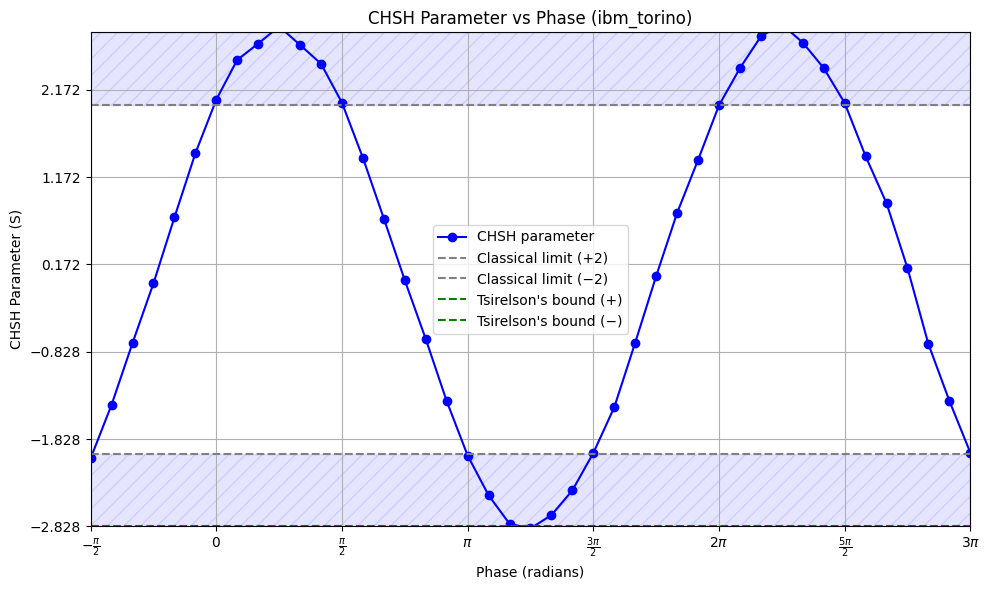

In [54]:
import matplotlib.pyplot as plt
import numpy as np

phases_extracted, S_extracted = zip(*outputs)

plt.figure(figsize=(10, 6))
plt.plot(phases_extracted, S_extracted, marker='o', linestyle='-', color='blue', label='CHSH parameter')

plt.xlim(-np.pi/2, 3*np.pi)
plt.ylim(-2*np.sqrt(2), 2*np.sqrt(2))

xticks = np.arange(-np.pi/2, 3*np.pi + 0.1, np.pi/2)
xtick_labels = [r"$-\frac{\pi}{2}$", r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$", r"$\frac{5\pi}{2}$", r"$3\pi$"]
plt.xticks(xticks, xtick_labels)

yticks = np.arange(-2*np.sqrt(2), 2*np.sqrt(2) + 0.1, 1)
plt.yticks(yticks)

plt.axhspan(2, 2*np.sqrt(2), facecolor='blue', alpha=0.1, hatch='//', edgecolor='blue')
plt.axhspan(-2*np.sqrt(2), -2, facecolor='blue', alpha=0.1, hatch='//', edgecolor='blue')

plt.axhline(y=2, color='gray', linestyle='--', label='Classical limit (+2)')
plt.axhline(y=-2, color='gray', linestyle='--', label='Classical limit (−2)')
plt.axhline(y=2*np.sqrt(2), color='green', linestyle='--', label="Tsirelson's bound (+)")
plt.axhline(y=-2*np.sqrt(2), color='green', linestyle='--', label="Tsirelson's bound (−)")

plt.title(f"CHSH Parameter vs Phase ({backend_name})")
plt.xlabel("Phase (radians)")
plt.ylabel("CHSH Parameter (S)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Version 1
Noisy simulation with one phase (pi/4)

In [173]:
circuits = []
input_pairs = []
for x_in in [0, 1]:
    for y_in in [0, 1]:
        input_pairs.append((x_in, y_in))
        circuits.append(gen_chsh(x_in, y_in, 6))

In [174]:
from qiskit_aer import AerSimulator
from qiskit import transpile

simulator = AerSimulator(noise_model=noise_model)
transpiled_circuits = [transpile(circ, simulator) for circ in circuits]

results = simulator.run(transpiled_circuits, shots=1024).result()
counts_list = [results.get_counts(i) for i in range(len(transpiled_circuits))]

In [171]:
def get_expectation(counts):
    agree = counts.get('00', 0) + counts.get('11', 0)
    disagree = counts.get('01', 0) + counts.get('10', 0)
    return (agree - disagree) / SHOTS if SHOTS > 0 else 0

expectations = []
for (x, y), counts in zip(input_pairs, counts_list):
    e = get_expectation(counts)
    print(f"E({x},{y}) = {e:.4f}")
    expectations.append(e)

# CHSH = E(0,0) + E(0,1) + E(1,0) - E(1,1)
chsh_value = abs(expectations[0] + expectations[1] + expectations[2] - expectations[3])
print(f"\nCHSH Value: {chsh_value:.4f}")

E(0,0) = 0.5938
E(0,1) = 0.6152
E(1,0) = 0.5996
E(1,1) = -0.6113

CHSH Value: 2.4199



--- Simulation Results (Counts) ---
Inputs (x=0, y=0):
  Outcomes (ba): {'00': 396, '01': 105, '10': 103, '11': 420}
Inputs (x=0, y=1):
  Outcomes (ba): {'00': 423, '01': 100, '10': 97, '11': 404}
Inputs (x=1, y=0):
  Outcomes (ba): {'00': 440, '01': 115, '10': 90, '11': 379}
Inputs (x=1, y=1):
  Outcomes (ba): {'00': 97, '01': 415, '10': 410, '11': 102}

Plotting results...


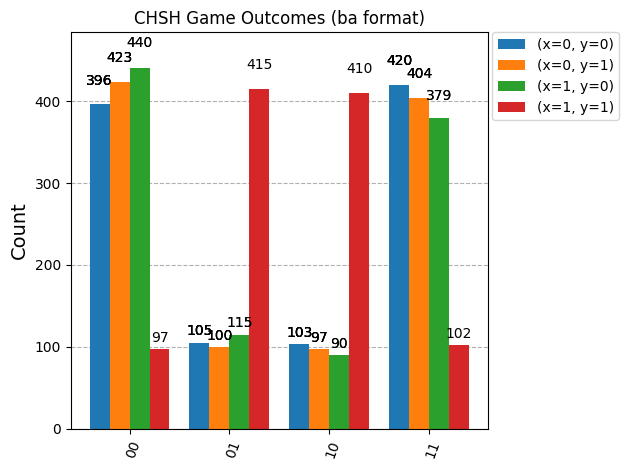

In [172]:
print("\n--- Simulation Results (Counts) ---")
for i, (x, y) in enumerate(input_pairs):
    print(f"Inputs (x={x}, y={y}):")
    sorted_counts = dict(sorted(counts_list[i].items()))
    print(f"  Outcomes (ba): {sorted_counts}")

print("\nPlotting results...")
display(qiskit.visualization.plot_histogram(counts_list,
                       legend=[f'(x={x}, y={y})' for x, y in input_pairs],
                       title='CHSH Game Outcomes (ba format)'))

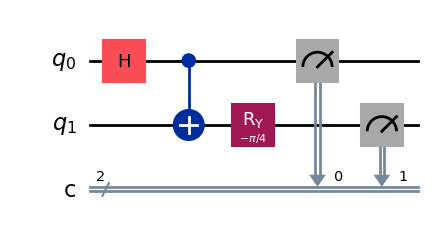

In [ ]:
qc = gen_chsh(0, 0, 2)

qc.draw('mpl')

In [3]:
def cx_chain(n_qubits):
    qc = qiskit.QuantumCircuit(n_qubits)

    half = int(n_qubits / 2)

    for i in range(half - 1):
        qc.cx(i, i + 1)
        qc.cx(i + 1, i)

        qc.cx(n_qubits - (i + 1), n_qubits - (i + 2))
        qc.cx(n_qubits - (i + 2), n_qubits - (i + 1))

    qc.cx(int(n_qubits/2)-1, int(n_qubits/2))

    for i in reversed(range(half - 1)):
        qc.cx(i + 1, i)
        qc.cx(i, i + 1)

        qc.cx(n_qubits - (i + 2), n_qubits - (i + 1))
        qc.cx(n_qubits - (i + 1), n_qubits - (i + 2))

    return qc

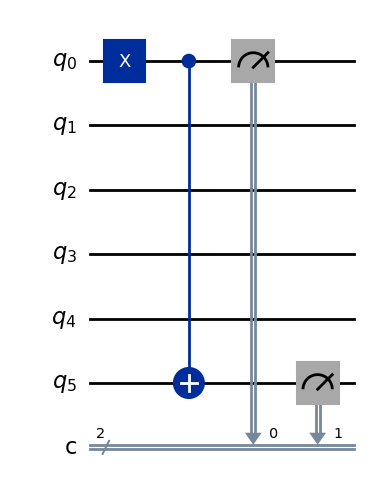

In [ ]:
custom_cnot = cx_chain(6).to_gate(label="CNOT")
qc = qiskit.QuantumCircuit(6, 2)

#qc.h(0)
qc.x(0)
#qc.append(custom_cnot, [0, 1, 2, 3, 4, 5])
qc.cx(0, 5) # used default since has lower depth after transplation
#qc.ry(-np.pi/4, 1)
qc.measure(0, 0)
qc.measure(5, 1)

qc.draw("mpl")

In [ ]:
print("Preparing circuits for the simulator...")
isa_qc_chsh = pm.run(qc)

sampler = Sampler(mode=backend)
counts = sampler.run([isa_qc_chsh], shots = 1000).result()[0].data .c.get_counts()


Preparing circuits for the simulator...


In [32]:
service = qiskit_ibm_runtime.QiskitRuntimeService()

In [33]:
print("The circuit depth is:", qc.depth())
qc_transpiled = qiskit.transpile(qc, service.backend('ibm_brisbane') , optimization_level=3)
print("The TRANSPILED circuit depth is:", qc_transpiled.depth())

The circuit depth is: 3
The TRANSPILED circuit depth is: 8
